# Exploratory Data Analysis

# 1. Libraries

In [1]:
#data storage and organization
import pandas #storage
import numpy as np #data-type conversion
from os import getcwd

#visual analysis
%matplotlib inline
import seaborn

#statistical analysis
    #Chi-Squared test
from scipy.stats import chi2_contingency
    #ANOVA
from scipy.stats import f_oneway
#import statsmodels.api as sm
#from statsmodels.formula.api import ols
    #MANOVA (Multivariate Analysis of Variance)
from statsmodels.multivariate.manova import MANOVA

# 2. Dataset - Importing

In [2]:
def cvSex(sex):
    mapper = {1: 'Male', 2: 'Female'}
    return mapper.get(sex)

def cvEducation(education):
    mapper = {1: 'Graduate', 2: 'University', 3: 'High School', 4: 'Others'}
    return mapper.get(education, 'Others') #takes care of cases 0, 5 and 6

def cvMarriage(marriage):
    mapper = {1: 'Married', 2: 'Single', 3: 'Divorced', 4: 'Others'}
    return mapper.get(marriage, 'Others') #takes care of 54 entries

def cvPayHistory(payHistory):
    mapper = {-2: 'No Credit Use', -1: 'Paid in Full', 0: 'Revolving Credit Used', 1: 'Delay 1 of month', 2: 'Delay 2 of months', 3: 'Delay 3 of months', 4: 'Delay 4 of months', 5: 'Delay 5 of months', 6: 'Delay 6 of months', 7: 'Delay 7 of months', 8: 'Delay 8 of months', 9: 'Delay 9 of months OR more'}
    return mapper.get(payHistory)


def cvDefPay(prediction):
    mapper = {0: False, 1: True}
    return mapper.get(prediction)

In [3]:
#BILL_AMT1 to PAY_AMT6 should NOT have 0 replaced with NAN
#dtype changed from int64 to int32 to save space and speed up computation, no data was lost
url = getcwd() + '\\default of credit card clients.xls'
ccd = pandas.read_excel(io = url, \
                        sheet_name='Data', header = 1, index_col = 0, \
                        dtype = {'LIMIT_BAL': np.int32, 'AGE': np.int32, 'BILL_AMT1': np.int32, 'BILL_AMT2': np.int32, 'BILL_AMT3': np.int32, 'BILL_AMT4': np.int32, 'BILL_AMT5': np.int32, 'BILL_AMT6': np.int32, 'PAY_AMT1': np.int32, 'PAY_AMT2': np.int32, 'PAY_AMT3': np.int32, 'PAY_AMT4': np.int32, 'PAY_AMT5': np.int32, 'PAY_AMT6': np.int32}, \
                        converters = {'SEX': cvSex, 'EDUCATION': cvEducation, 'MARRIAGE': cvMarriage, 'default payment next month': cvDefPay, 'PAY_0': cvPayHistory, 'PAY_2': cvPayHistory, 'PAY_3': cvPayHistory, 'PAY_4': cvPayHistory, 'PAY_5': cvPayHistory, 'PAY_6': cvPayHistory,})

In [4]:
ccd.rename(columns = {'PAY_0': 'PAY_1'}, inplace = True)
ccd.rename(columns = {'default payment next month': 'default_payment_next_month'}, inplace = True)

# 3. Exploratory Data Analysis

### Segments:
#### 1. Personal

#### 2. Financial
1. Expended
2. Paid
3. Behaviour

## 3.1. Overall Dataset EDA

In [5]:
#check for missing values
ccd.isnull().values.any()

False

## 3.2. Variable wise' EDA

### Univariate:
1. Distribution
2. Outlier detection

### Bivariate:
1. Continuous - Continuous: Correlation Co-efficient{Pearson, Spearman}. [-1 <= p-value >= +1]

2. Continuous - Categorical: Analysis of Variance(ANOVA): Determine whether the differences between group means are statistically significant. [α = 0.05]

3. Categorical - Categorical: Chi-Square test. [α > 0.05 for insignificance]

### 3.2.a. LIMIT_BAL

Type - Numerical - Continuous - Ratio

Segment - Financial - Behaviour

Comments - None

#### i> Univariate

<AxesSubplot:xlabel='LIMIT_BAL', ylabel='Frequency'>

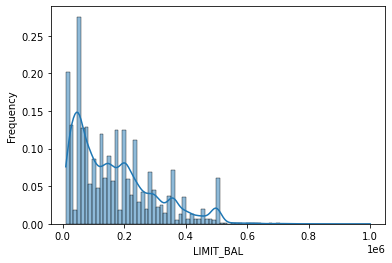

In [6]:
#for distribution and density
seaborn.histplot(data = ccd['LIMIT_BAL'], stat = 'frequency', kde = True, discrete = False, bins = ccd['LIMIT_BAL'].value_counts().size)
#ccd['LIMIT_BAL'].value_counts().size == 81

<AxesSubplot:xlabel='LIMIT_BAL'>

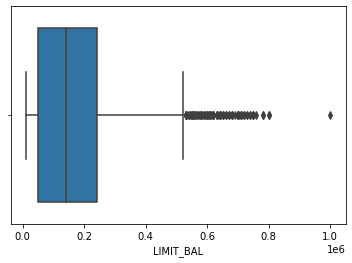

In [7]:
#for outliers
seaborn.boxplot(x = 'LIMIT_BAL', data = ccd)

#### ii> Bivariate Graphical

<AxesSubplot:xlabel='default_payment_next_month', ylabel='LIMIT_BAL'>

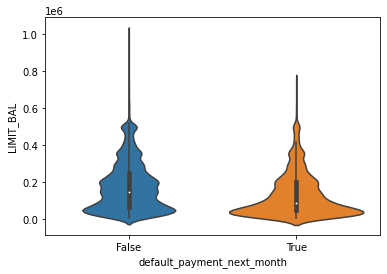

In [8]:
#for relation between LIMIT_BAL and target variable
seaborn.violinplot(x = ccd['default_payment_next_month'], y = ccd['LIMIT_BAL'])

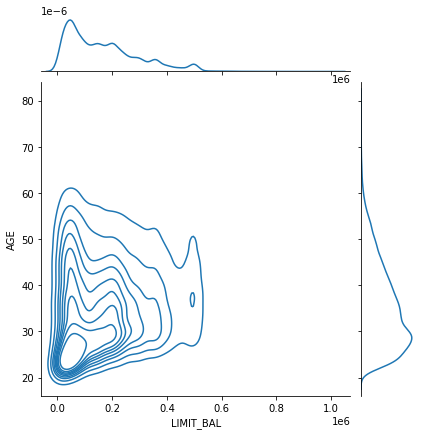

In [9]:
#for relation between LIMIT_BAL and AGE
seaborn.jointplot(x = ccd['LIMIT_BAL'], y = ccd['AGE'], kind = 'kde')

#### iii> Bivariate Statistical

In [10]:
ccd.groupby('default_payment_next_month').agg([np.mean, np.median, np.count_nonzero, np.std]).LIMIT_BAL

,mean,median,count_nonzero,std
default_payment_next_month,,,,
False,178099.726074,150000,23364,131628.359660
True,130109.656420,90000,6636,115378.540571


#### iii> b. ANOVA - F One-Way

In [11]:
f_oneway(ccd['LIMIT_BAL'][ccd['default_payment_next_month'] == True],
        ccd['LIMIT_BAL'][ccd['default_payment_next_month'] == False])

F_onewayResult(statistic=724.0685392611651, pvalue=1.3022439532706416e-157)

#### iv> Conclusion
Expectation - 
1. Balance limit will vary with age (professionals accumulate wealth over their career, thus alloting them higher limits as they age is logical.)
2. Majority of credit availers are likely to have lower limit, possibly sharing the same LIMIT_BAL bracket.

Conclusion -
1. (Plot 3) Distribution is highly concentrated on [20>=AGE<=30, 0>=LIMIT_BAL<=200000], however distribution is also expanding on the axes.
2. True, defaulters are more likely to be having LIMIT_BAL in lower limits (LIMIT_BAL <= 200000). (Plot 1)
3. People with higher LIMIT_BAL are less likely to default. (LIMIT_BAL >= 400000) (Plot 2 density, Crosstab)
4. One-Way ANOVA: p-value being below 0.05, difference between means is statistically significant to a very high degree. There exists a strong relation between LIMIT_BAL and 'default payment'.

Comments - The variable being 'Balance Limit' is likely to be directly correlated to wealth, it's not unusual to have outliers.

### 3.2.b. SEX

Type - Categorical - Nominal

Segment - Personal

Legend - 1: Male; 2: Female

#### i> Univariate

In [12]:
#for distrubution
ccd['SEX'].value_counts()

Female    18112
Male      11888
Name: SEX, dtype: int64

In [13]:
ccd['SEX'].value_counts(normalize = True).mul(100).round(2).astype('str') + ' %'

Female    60.37 %
Male      39.63 %
Name: SEX, dtype: object

#### ii> Bivariate Graphical

<AxesSubplot:xlabel='SEX', ylabel='count'>

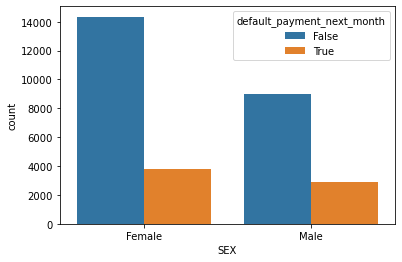

In [14]:
#for relation between SEX and target variable
seaborn.countplot(hue = 'default_payment_next_month', x = 'SEX', data = ccd)

<AxesSubplot:xlabel='SEX', ylabel='LIMIT_BAL'>

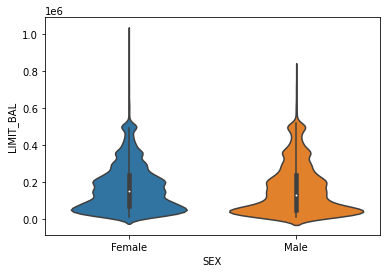

In [15]:
#for relation between LIMIT_BAL and SEX
seaborn.violinplot(x = ccd['SEX'], y = ccd['LIMIT_BAL'])

#### iii> Bivariate Statistical

In [16]:
pandas.crosstab(index = ccd['default_payment_next_month'], columns = ccd['SEX'])

SEX,Female,Male
default_payment_next_month,,
False,14349,9015
True,3763,2873


In [17]:
#category wise
pandas.crosstab(index = ccd['default_payment_next_month'], columns = ccd['SEX'], normalize = 'columns').mul(100).round(2).astype('str') + ' %'

SEX,Female,Male
default_payment_next_month,,
False,79.22 %,75.83 %
True,20.78 %,24.17 %


In [18]:
#target wise
pandas.crosstab(index = ccd['default_payment_next_month'], columns = ccd['SEX'], normalize = 'index').mul(100).round(2).astype('str') + ' %'

SEX,Female,Male
default_payment_next_month,,
False,61.41 %,38.59 %
True,56.71 %,43.29 %


#### iii> b. Chi Squared Test

In [19]:
chi2 = pandas.DataFrame(data = chi2_contingency(observed = pandas.crosstab(index = ccd['default_payment_next_month'], columns = ccd['SEX'])))

In [20]:
chi2

,0
0,47.7088
1,4.94468e-12
2,1
3,"[[14105.6256, 9258.3744], [4006.3744, 2629.6256]]"


In [21]:
chi2[0][3].min()

2629.6256

#### iv> Conclusion
Expectation - 
1. Both seses will have similar credit avail count.
2. Default payment will be similar for both sexes.
3. LIMIT_BAL will be similar for both sexes.

Conclusion - 
1. False, Females are more likely to avail credit. (Female: 60.37%, Male:39.63%) (Distribution)
2. True. (default: False : [Female: 79.22%, Male: 75.83%]) (Crosstab 2)
3. True. (Plot 2)
4. Chi-Sqaured test: p-value being below 0.05(row 2), there exists a relation between SEX and 'default payment'. All elements of array of expected frequency(row 4) being above 5, test is reliable.

Comments - None

### 3.2.c. EDUCATION

Type - Categorical - Ordinal

Segment - Personal

Legend - 1: Graduate; 2: University; 3: HighSchool; 0,4,5,6: Others 

#### i> Univariate

In [22]:
#for distrubution
ccd['EDUCATION'].value_counts()

University     14030
Graduate       10585
High School     4917
Others           468
Name: EDUCATION, dtype: int64

In [23]:
ccd['EDUCATION'].value_counts(normalize = True).mul(100).round(2).astype('str') + ' %'

University     46.77 %
Graduate       35.28 %
High School    16.39 %
Others          1.56 %
Name: EDUCATION, dtype: object

#### ii> Bivariate Graphical

<AxesSubplot:xlabel='EDUCATION', ylabel='count'>

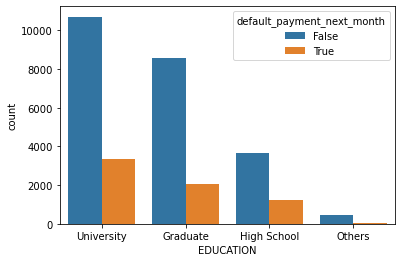

In [24]:
#for relation between EDUCATION and target variable
seaborn.countplot(hue = 'default_payment_next_month', x = 'EDUCATION', data = ccd)

#### iii> Bivariate Statistical

In [25]:
pandas.crosstab(index = ccd['default_payment_next_month'], columns = ccd['EDUCATION'])

EDUCATION,Graduate,High School,Others,University
default_payment_next_month,,,,
False,8549,3680,435,10700
True,2036,1237,33,3330


In [26]:
#category wise
pandas.crosstab(index = ccd['default_payment_next_month'], columns = ccd['EDUCATION'], normalize = 'columns').mul(100).round(2).astype('str') + ' %'

EDUCATION,Graduate,High School,Others,University
default_payment_next_month,,,,
False,80.77 %,74.84 %,92.95 %,76.27 %
True,19.23 %,25.16 %,7.05 %,23.73 %


In [27]:
#target wise
pandas.crosstab(index = ccd['default_payment_next_month'], columns = ccd['EDUCATION'], normalize = 'index').mul(100).round(2).astype('str') + ' %'

EDUCATION,Graduate,High School,Others,University
default_payment_next_month,,,,
False,36.59 %,15.75 %,1.86 %,45.8 %
True,30.68 %,18.64 %,0.5 %,50.18 %


#### iii> b. Chi Squared Test

In [28]:
chi2 = pandas.DataFrame(data = chi2_contingency(observed = pandas.crosstab(index = ccd['default_payment_next_month'], columns = ccd['EDUCATION'])))

In [29]:
chi2

,0
0,160.41
1,1.49506e-34
2,3
3,"[[8243.598, 3829.3596, 364.4784, 10926.564], [..."


In [30]:
chi2[0][3].min()

103.5216

#### iv> Conclusion
Expectation - 
1. Lower EDUCATION will directly correlate with higher defaulter rate.
2. Lower EDUCATION will result in higher rate of loan availing.

Conclusion - 
1. Discernible trend - Graduates have the least default rate. (NOTE: Category Others has too small sample space to draw an accurate inference) (High School: 74.84 %, Graduate: 80.77 %, University: 76.27 %, Others: 92.95 %) (Crosstab 2)
2. On the contrary, higher EDUCATION levels results in higher rate of availing loan. (Crosstab 3, Plot)
3. Chi-Sqaured test: p-value being below 0.05(row 2), there exists a relation between EDUCATION and 'default payment'. All elements of array of expected frequency(row 4) being above 5, test is reliable.

Comments - None

### 3.2.d MARRIAGE

Type - Categorical - Nominal

Segment - Personal

Legend - 1: Married, 2: Single, 3: Divorced, 4: Others

#### i> Univariate

In [31]:
#for distrubution
ccd['MARRIAGE'].value_counts()

Single      15964
Married     13659
Divorced      323
Others         54
Name: MARRIAGE, dtype: int64

In [32]:
ccd['MARRIAGE'].value_counts(normalize = True).mul(100).round(2).astype('str') + ' %'

Single      53.21 %
Married     45.53 %
Divorced     1.08 %
Others       0.18 %
Name: MARRIAGE, dtype: object

#### ii> Bivariate Graphical

<AxesSubplot:xlabel='MARRIAGE', ylabel='count'>

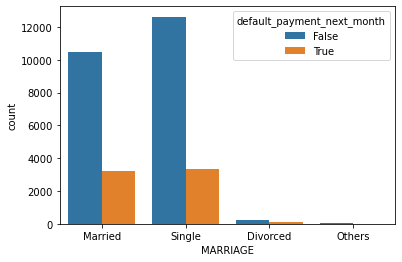

In [33]:
#for relation between MARRIAGE and target variable
seaborn.countplot(hue = 'default_payment_next_month', x = 'MARRIAGE', data = ccd)

#### iii> Bivariate Statistical

In [34]:
pandas.crosstab(index = ccd['default_payment_next_month'], columns = ccd['MARRIAGE'])

MARRIAGE,Divorced,Married,Others,Single
default_payment_next_month,,,,
False,239,10453,49,12623
True,84,3206,5,3341


In [35]:
#category wise
pandas.crosstab(index = ccd['default_payment_next_month'], columns = ccd['MARRIAGE'], normalize = 'columns').mul(100).round(2).astype('str') + ' %'

MARRIAGE,Divorced,Married,Others,Single
default_payment_next_month,,,,
False,73.99 %,76.53 %,90.74 %,79.07 %
True,26.01 %,23.47 %,9.26 %,20.93 %


In [36]:
#target wise
pandas.crosstab(index = ccd['default_payment_next_month'], columns = ccd['MARRIAGE'], normalize = 'index').mul(100).round(2).astype('str') + ' %'

MARRIAGE,Divorced,Married,Others,Single
default_payment_next_month,,,,
False,1.02 %,44.74 %,0.21 %,54.03 %
True,1.27 %,48.31 %,0.08 %,50.35 %


#### iii> b. Chi Squared Test

In [37]:
chi2 = pandas.DataFrame(data = chi2_contingency(observed = pandas.crosstab(index = ccd['default_payment_next_month'], columns = ccd['MARRIAGE'])))

In [38]:
chi2

,0
0,35.6624
1,8.82586e-08
2,3
3,"[[251.5524, 10637.6292, 42.0552, 12432.7632], ..."


In [39]:
chi2[0][3].min()

11.9448

#### iv> Conclusion
Expectation - 
1. More singles will avail credit, likely due to poorer financial planning.
2. Divorced people may have higher rate of defaulting.
3. Married individuals will be least likely to default.

Conclusion - 
1. True, however difference between categories isn't very significant (Single: 53.21 %, Married: 45.53 %) (Distribution 2)
2. True, 26.01% of Divorced individuals default. (Married: 23.47%, Singles: 20.93%) (Crosstab 2)
3. False, 23.47% Married individuals default, but 20.93% Singles default, singles are least likely to default. (Crosstab 2)
4. Chi-Sqaured test: p-value being below 0.05(row 2), there exists a relation between MARRIAGE and 'default payment'. All elements of array of expected frequency(previous cell) being above 5, test is reliable.

Comments - None

### 3.2.e AGE

Type - Numerical - Continuous - Ratio

Segment - Personal

Legend - Count of Years as Integers

#### i> Univariate

<AxesSubplot:xlabel='AGE', ylabel='Frequency'>

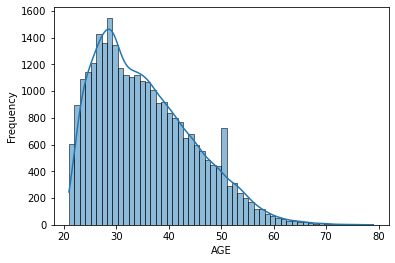

In [40]:
#for distribution and density
seaborn.histplot(data = ccd['AGE'], stat = 'frequency', kde = True, discrete = False, bins = ccd['AGE'].value_counts().size)
#ccd['AGE'].value_counts().size = 56

<AxesSubplot:xlabel='AGE'>

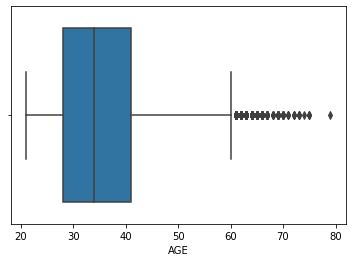

In [41]:
#for outliers
seaborn.boxplot(x = 'AGE', data = ccd)

#### ii> Bivariate Graphical

<AxesSubplot:xlabel='default_payment_next_month', ylabel='AGE'>

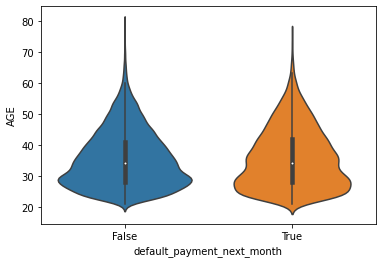

In [42]:
seaborn.violinplot(x = ccd['default_payment_next_month'], y = ccd['AGE'])

#### iii> Bivariate Statistical

In [43]:
ccd.groupby('default_payment_next_month').agg([np.mean, np.median, np.count_nonzero, np.std]).AGE

,mean,median,count_nonzero,std
default_payment_next_month,,,,
False,35.417266,34,23364,9.077355
True,35.725738,34,6636,9.693438


#### iii> b. ANOVA - F One-Way

In [44]:
#One-Way ANOVA
f_oneway(ccd['AGE'][ccd['default_payment_next_month'] == True],
        ccd['AGE'][ccd['default_payment_next_month'] == False])

F_onewayResult(statistic=5.7885558246720565, pvalue=0.016136845890286453)

#### iv> Conclusion

Expectation - 
1. Credit user demographics will skew towards younger generation.
2. Younger credit users will be more likely to default on payment.

Conclusion - 
1. True. by kernel density plot, significant portion of individual are from the demographic 25>=AGE<=35. (Plot 1)
2. False, Plots for defaulting and non-defaulting individuals are similar. The higher density for 25>=AGE<=35 directly corresponds with the kernel distribution for AGE. (ViolinPlot, Distribution Plot)
3. One-Way ANOVA: p-value being below 0.05, but not near 0, difference between means is statistically significant to a degree. There exists a relation between AGE and 'default payment'.

Comments - None

### 3.2.f PAY {PAY_1 to PAY_6}

Type - Categorical - Ordinal

Segment - Financial - Behaviour

Legend - 

{PAY_1: September 2005, PAY_2: August 2005, PAY_3: July 2005, PAY_4: June 2005, PAY_5: May 2005, PAY_6: April 2005}

{-2: 'No Credit Use', -1: 'Paid in Full', 0: 'Revolving Credit Used', 1: 'Delay 1 of month', 2: 'Delay 2 of months', 3: 'Delay 3 of months', 4: 'Delay 4 of months', 5: 'Delay 5 of months', 6: 'Delay 6 of months', 7: 'Delay 7 of months', 8: 'Delay 8 of months', 9: 'Delay 9 of months OR more'}

#### i> Dimentionalty Reduction
NOTE: Using mode to aggregate. An entry may have mutiple mode values (same frequency), to resolve, using severest class.

In [45]:
ccdr = pandas.read_excel(io = url, 
                        sheet_name='Data', header = 1, index_col = 0)
ccdr.rename(columns = {'PAY_0': 'PAY_1'}, inplace = True)

In [46]:
ccdHistory = ccd[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
ccdrHistory = ccdr[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]

NOTE: Why severest value? To ensure fiscally fit population of credit users.

In [47]:
ccdrHistoryMode = ccdrHistory.mode(axis = 'columns')
ccdrHistorySeverest = ccdrHistoryMode.apply(func = max, axis = 'columns')
ccdPayHistoryMode = map(cvPayHistory, ccdrHistorySeverest)

In [48]:
ccd['PAY_MODE_SEVEREST'] = list(ccdPayHistoryMode)

#### ii> Univariate

In [49]:
ccd['PAY_MODE_SEVEREST'].value_counts()

Revolving Credit Used    17076
Paid in Full              5691
No Credit Use             3897
Delay 2 of months         3047
Delay 3 of months          104
Delay 7 of months           67
Delay 4 of months           58
Delay 8 of months           23
Delay 5 of months           17
Delay 6 of months           11
Delay 1 of month             9
Name: PAY_MODE_SEVEREST, dtype: int64

In [50]:
ccd[ccd['PAY_MODE_SEVEREST'] == 'Delay 9 of months OR more']

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month,PAY_MODE_SEVEREST
ID,,,,,,,,,,,,,,,,,,,,,


In [51]:
ccd['PAY_MODE_SEVEREST'].value_counts(normalize = True).mul(100).round(2).astype('str') + ' %'

Revolving Credit Used    56.92 %
Paid in Full             18.97 %
No Credit Use            12.99 %
Delay 2 of months        10.16 %
Delay 3 of months         0.35 %
Delay 7 of months         0.22 %
Delay 4 of months         0.19 %
Delay 8 of months         0.08 %
Delay 5 of months         0.06 %
Delay 6 of months         0.04 %
Delay 1 of month          0.03 %
Name: PAY_MODE_SEVEREST, dtype: object

#### iii> Bivariate Graphical

<AxesSubplot:xlabel='PAY_MODE_SEVEREST', ylabel='count'>

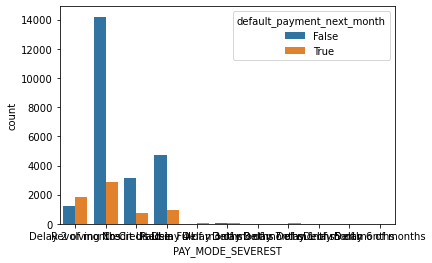

In [52]:
seaborn.countplot(hue = 'default_payment_next_month', x = 'PAY_MODE_SEVEREST', data = ccd)

#### iv> Bivariate Statistical

In [53]:
pandas.crosstab(index = ccd['default_payment_next_month'], columns = ccd['PAY_MODE_SEVEREST'])

PAY_MODE_SEVEREST,Delay 1 of month,Delay 2 of months,Delay 3 of months,Delay 4 of months,Delay 5 of months,Delay 6 of months,Delay 7 of months,Delay 8 of months,No Credit Use,Paid in Full,Revolving Credit Used
default_payment_next_month,,,,,,,,,,,
False,8,1198,28,24,7,4,11,10,3136,4744,14194
True,1,1849,76,34,10,7,56,13,761,947,2882


In [54]:
#category-wise
pandas.crosstab(index = ccd['default_payment_next_month'], columns = ccd['PAY_MODE_SEVEREST'], normalize = 'columns').mul(100).round(2).astype('str') + ' %'

PAY_MODE_SEVEREST,Delay 1 of month,Delay 2 of months,Delay 3 of months,Delay 4 of months,Delay 5 of months,Delay 6 of months,Delay 7 of months,Delay 8 of months,No Credit Use,Paid in Full,Revolving Credit Used
default_payment_next_month,,,,,,,,,,,
False,88.89 %,39.32 %,26.92 %,41.38 %,41.18 %,36.36 %,16.42 %,43.48 %,80.47 %,83.36 %,83.12 %
True,11.11 %,60.68 %,73.08 %,58.62 %,58.82 %,63.64 %,83.58 %,56.52 %,19.53 %,16.64 %,16.88 %


In [55]:
#target-wise
pandas.crosstab(index = ccd['default_payment_next_month'], columns = ccd['PAY_MODE_SEVEREST'], normalize = 'index').mul(100).round(2).astype('str') + ' %'

PAY_MODE_SEVEREST,Delay 1 of month,Delay 2 of months,Delay 3 of months,Delay 4 of months,Delay 5 of months,Delay 6 of months,Delay 7 of months,Delay 8 of months,No Credit Use,Paid in Full,Revolving Credit Used
default_payment_next_month,,,,,,,,,,,
False,0.03 %,5.13 %,0.12 %,0.1 %,0.03 %,0.02 %,0.05 %,0.04 %,13.42 %,20.3 %,60.75 %
True,0.02 %,27.86 %,1.15 %,0.51 %,0.15 %,0.11 %,0.84 %,0.2 %,11.47 %,14.27 %,43.43 %


#### Payment behaviour in June (Quarter - April to June) (PAY_4: June)

In [56]:
pandas.crosstab(index = ccd['default_payment_next_month'], columns = ccd['PAY_4'])

PAY_4,Delay 1 of month,Delay 2 of months,Delay 3 of months,Delay 4 of months,Delay 5 of months,Delay 6 of months,Delay 7 of months,Delay 8 of months,No Credit Use,Paid in Full,Revolving Credit Used
default_payment_next_month,,,,,,,,,,,
False,1,1506,70,23,17,3,10,1,3511,4783,13439
True,1,1653,110,46,18,2,48,1,837,904,3016


In [57]:
#target-wise
pandas.crosstab(index = ccd['default_payment_next_month'], columns = ccd['PAY_4'], normalize = 'index').mul(100).round(2).astype('str') + ' %'

PAY_4,Delay 1 of month,Delay 2 of months,Delay 3 of months,Delay 4 of months,Delay 5 of months,Delay 6 of months,Delay 7 of months,Delay 8 of months,No Credit Use,Paid in Full,Revolving Credit Used
default_payment_next_month,,,,,,,,,,,
False,0.0 %,6.45 %,0.3 %,0.1 %,0.07 %,0.01 %,0.04 %,0.0 %,15.03 %,20.47 %,57.52 %
True,0.02 %,24.91 %,1.66 %,0.69 %,0.27 %,0.03 %,0.72 %,0.02 %,12.61 %,13.62 %,45.45 %


#### Payment behaviour in June (Quarter - July to September) (PAY_1: September)

In [58]:
pandas.crosstab(index = ccd['default_payment_next_month'], columns = ccd['PAY_1'])

PAY_1,Delay 1 of month,Delay 2 of months,Delay 3 of months,Delay 4 of months,Delay 5 of months,Delay 6 of months,Delay 7 of months,Delay 8 of months,No Credit Use,Paid in Full,Revolving Credit Used
default_payment_next_month,,,,,,,,,,,
False,2436,823,78,24,13,5,2,8,2394,4732,12849
True,1252,1844,244,52,13,6,7,11,365,954,1888


In [59]:
#target-wise
pandas.crosstab(index = ccd['default_payment_next_month'], columns = ccd['PAY_1'], normalize = 'index').mul(100).round(2).astype('str') + ' %'

PAY_1,Delay 1 of month,Delay 2 of months,Delay 3 of months,Delay 4 of months,Delay 5 of months,Delay 6 of months,Delay 7 of months,Delay 8 of months,No Credit Use,Paid in Full,Revolving Credit Used
default_payment_next_month,,,,,,,,,,,
False,10.43 %,3.52 %,0.33 %,0.1 %,0.06 %,0.02 %,0.01 %,0.03 %,10.25 %,20.25 %,54.99 %
True,18.87 %,27.79 %,3.68 %,0.78 %,0.2 %,0.09 %,0.11 %,0.17 %,5.5 %,14.38 %,28.45 %


#### iv> b. Chi Squared Test

In [60]:
chi2 = pandas.DataFrame(data = chi2_contingency(observed = pandas.crosstab(index = ccd['default_payment_next_month'], columns = ccd['PAY_MODE_SEVEREST'])))

In [61]:
chi2

,0
0,3406.33
1,0
2,10
3,"[[7.0092, 2373.0036, 80.9952, 45.1704, 13.2396..."


In [62]:
chi2[0][3].min()

1.9908

#### v> Conclusion
Expectation - 
1. Individual may default less at the end of a financial quarter (PAY_1: September, Pay_4: June)
2. Payment delay and smaller LIMIT_BAL can be directly correlated. (Resulatant of sound and logical practices of the Credit firm)

Conclusion - 
1. Holds True for June, but it's the opposite case for September. PAY_{} == Delay{} AND Default == True: {'PAY_MODE_SEVEREST': 30.84%, 'PAY_4': 28.32%, 'PAY_1': 51.69%} (Crosstabs 3, 5 and 7, normalized by index).
2. True (Crosstab 2)
3. Chi-Sqaured test: p-value being below 0.05(row 2), there exists a relation between PAY_MODE_SEVEREST and 'default payment'. All elements of array of expected frequency(previous cell) not being above 5, test is not reliable.

Comments - None

### 3.2.g BILL_AMT {BILL_AMT1 to BILL_AMT6}

Type - Numerical - Continuous - Ratio

Segment - Financial - Expended

Legend - 

{BILL_AMT_1: September 2005, BILL_AMT_2: August 2005, BILL_AMT_3: July 2005, BILL_AMT_4: June 2005, BILL_AMT_5: May 2005, BILL_AMT_6: April 2005}

#### i> Dimentionalty Reduction

In [63]:
ccdSpent = ccd[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]

#using mean for total credit used
ccd['BILL_AMT_MEAN'] = np.int32(ccdSpent.mean(axis = 'columns').round())

<AxesSubplot:>

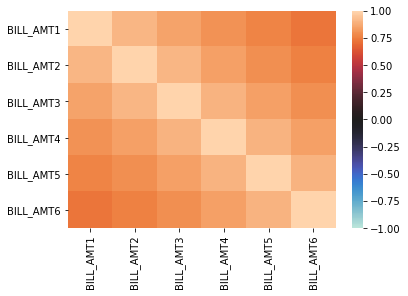

In [64]:
#correlation between this set of similar, historical variables
ccdSpentCorrSp = ccdSpent.corr(method='spearman')

seaborn.heatmap(data = ccdSpentCorrSp, vmin = -1, vmax = 1, center = 0)

<AxesSubplot:>

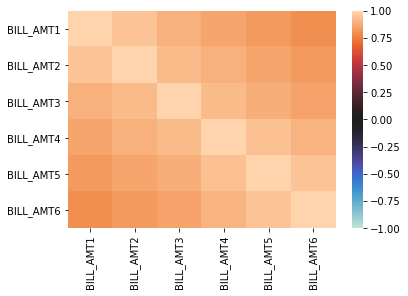

In [65]:
#correlation between this set of similar, historical variables
ccdSpentCorrPr = ccdSpent.corr(method='pearson')

seaborn.heatmap(data = ccdSpentCorrPr, vmin = -1, vmax = 1, center = 0)

#### ii> Univariate

<AxesSubplot:xlabel='BILL_AMT_MEAN', ylabel='Frequency'>

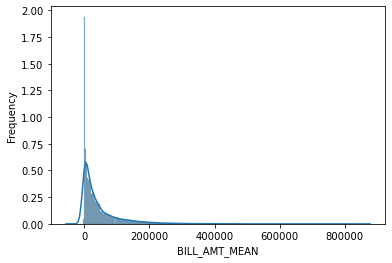

In [66]:
#for distribution and density
seaborn.histplot(data = ccd['BILL_AMT_MEAN'], stat = 'frequency', kde = True, discrete = False, bins = 300)
#bins = 300 because dataframe's size = 30000

<AxesSubplot:xlabel='BILL_AMT_MEAN'>

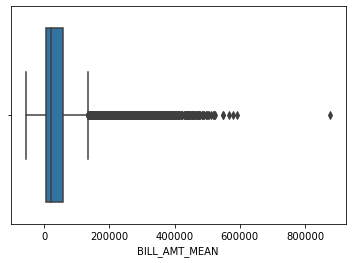

In [67]:
#for outliers
seaborn.boxplot(x = 'BILL_AMT_MEAN', data = ccd)

#### iii> Bivariate Graphical

<AxesSubplot:xlabel='default_payment_next_month', ylabel='BILL_AMT_MEAN'>

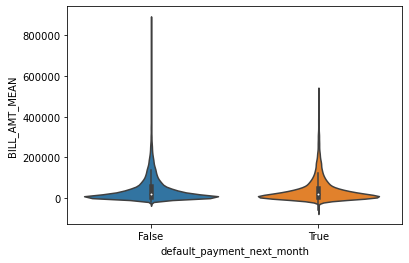

In [68]:
#for relation between mean of credit used and target variable
seaborn.violinplot(x = ccd['default_payment_next_month'], y = ccd['BILL_AMT_MEAN'], jitter = 0.4)

#### iv> Bivariate Statistical

In [69]:
ccd.groupby('default_payment_next_month').agg([np.mean, np.median, np.count_nonzero, np.std]).BILL_AMT_MEAN

,mean,median,count_nonzero,std
default_payment_next_month,,,,
False,45404.815913,21443.5,22811,62958.655472
True,43470.493068,19781.5,6319,64295.087885


#### iv> b. ANOVA - F One-Way

In [70]:
f_oneway(ccd['BILL_AMT_MEAN'][ccd['default_payment_next_month'] == True],
        ccd['BILL_AMT_MEAN'][ccd['default_payment_next_month'] == False])

F_onewayResult(statistic=4.832561995267136, pvalue=0.027934710811609496)

#### v> Conclusion
Expectation - 
1. High correlation among BILL_AMT{} variables.
2. Correlation between spending habits of consecutive months will be stronger than that of the months which are far apart.
3. Defaulters are more likely to have negative BILL_AMT_MEAN. (Individual's habits, complacency)

Conclusion - 
1. True, Very strong correlation. [Highest: BILL_AMT1 and BILL_AMT2: 0.911133, Lowest: BILL_AMT1 and BILL_AMT6: 0.734275]. (Correlation Table)
2. True, this holds true in all observable cases, thus a trend is established from this hypotheses. [Highest: BILL_AMT1 and BILL_AMT2: 0.911133, Lowest: BILL_AMT1 and BILL_AMT6: 0.734275] (Correlation Table)
3. True. (Plot 2)
4. One-Way ANOVA: p-value being below 0.05 but not near 0, difference between means is statistically significant to a small degree. There exists a relation between BILL_AMT_MEAN and 'default payment'.

Comments - 
1. This set of variables can have valid negative values, which represent cases where credit company owes monet to an individual.
2. Due to the very strong correlation, the variables can undergo dimentionality reduction.

### 3.2.h PAY_AMT {PAY_AMT1 to PAY_AMT6}

Type - Numerical - Continuous - Ratio

Segment - Financial - Paid

Legend - 

{PAY_AMT1: September 2005, PAY_AMT2: August 2005, PAY_AMT3: July 2005, PAY_AMT4: June 2005, PAY_AMT5: May 2005, PAY_AMT6: April 2005}

#### i> Dimentionalty Reduction

In [71]:
ccdSettled = ccd[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]

#using mean for total credit settled
ccd['PAY_AMT_MEAN'] = np.int32(ccdSettled.mean(axis = 'columns').round())

<AxesSubplot:>

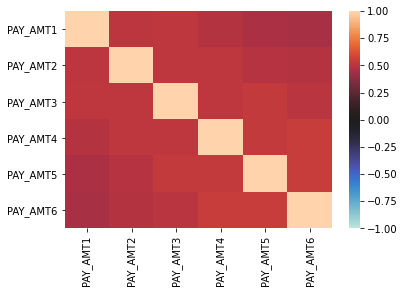

In [72]:
#correlation between this set of similar, historical variables
ccdSettledCorrSp = ccdSettled.corr(method='spearman')

seaborn.heatmap(data = ccdSettledCorrSp, vmin = -1, vmax = 1, center = 0)

<AxesSubplot:>

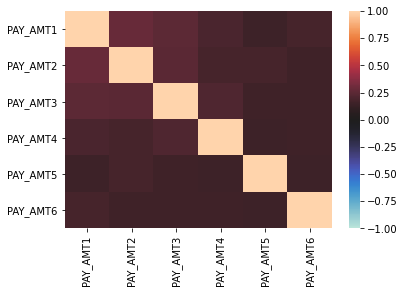

In [73]:
#correlation between this set of similar, historical variables
ccdSettledCorrPr = ccdSettled.corr(method='pearson')

seaborn.heatmap(data = ccdSettledCorrPr, vmin = -1, vmax = 1, center = 0)

#### ii> Univariate

<AxesSubplot:xlabel='PAY_AMT_MEAN', ylabel='Frequency'>

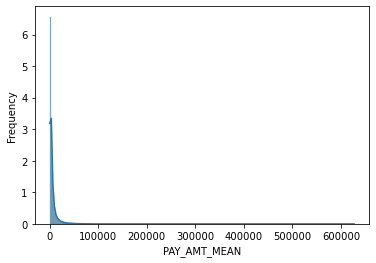

In [74]:
#distribution
seaborn.histplot(data = ccd['PAY_AMT_MEAN'], stat = 'frequency', kde = True, discrete = False, bins = 300)
#bins = 300 because dataframe's size = 30000

<AxesSubplot:xlabel='PAY_AMT_MEAN'>

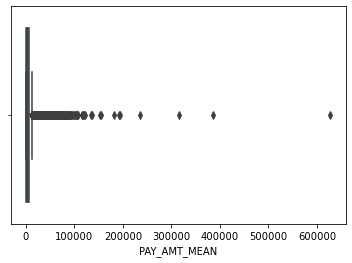

In [75]:
#for outliers
seaborn.boxplot(x = 'PAY_AMT_MEAN', data = ccd)

#### iii> Bivariate Graphical

<AxesSubplot:xlabel='default_payment_next_month', ylabel='PAY_AMT_MEAN'>

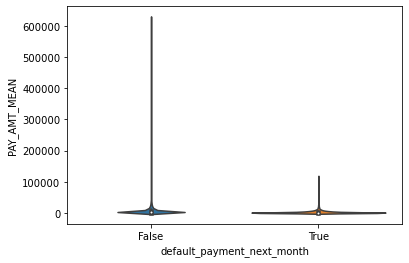

In [76]:
#for relation between mean of credit settled and target variable
seaborn.violinplot(x = ccd['default_payment_next_month'], y = ccd['PAY_AMT_MEAN'], jitter = 0.4)

#### iv> Bivariate Statistical

In [77]:
ccd.groupby('default_payment_next_month').agg([np.mean, np.median, np.count_nonzero, np.std]).PAY_AMT_MEAN

,mean,median,count_nonzero,std
default_payment_next_month,,,,
False,5828.236518,2754.0,22476,10947.043382
True,3328.214436,1612.5,6091,6152.608821


#### iv> b. ANOVA - F One-Way

In [78]:
f_oneway(ccd['PAY_AMT_MEAN'][ccd['default_payment_next_month'] == True],
        ccd['PAY_AMT_MEAN'][ccd['default_payment_next_month'] == False])

F_onewayResult(statistic=317.5991881610729, pvalue=1.118575394978374e-70)

#### v> Conclusion
Expectation - 
1. High correlation among PAY_AMT{} variables.
2. Correlation between credit paying habits of consecutive months will be weaker than that of the months which are far apart.
3. Defaulters are more likely to have low PAY_AMT_MEAN. (Individual's weak financial health)

Conclusion - 
1. Positive correlation, but not very strong. [Highest: PAY_AMT1 and PAY_AMT3: 0.51942, Lowest: PAY_AMT1 and PAY_AMT6: 0.455322]. (Correlation Table)
2. True, with exception. [PAY_AMT1 and PAY_AMT3: 0.51942, PAY_AMT1 and PAY_AMT2: 0.511614]. (Correlation Table)
3. True. (Table 3)
4. One-Way ANOVA: p-value being below 0.05, difference between means is statistically significant. There is strong relation between PAY_AMT_MEAN and 'default payment'.

### 3.2.i Correlation between Availing and Paying back Credit

In [79]:
ccdAvailPayback = ccd[['PAY_AMT_MEAN', 'BILL_AMT_MEAN']]
ccdAvailPayback.corr(method = 'spearman')

,PAY_AMT_MEAN,BILL_AMT_MEAN
PAY_AMT_MEAN,1.000000,0.597273
BILL_AMT_MEAN,0.597273,1.000000


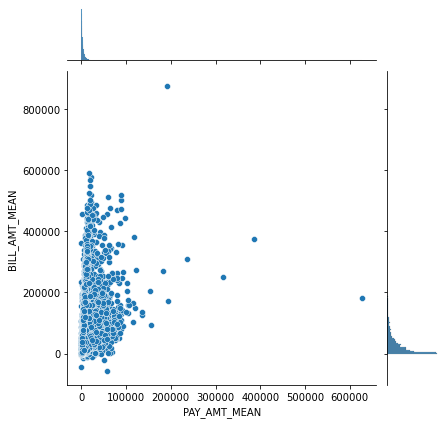

In [80]:
seaborn.jointplot(x = ccd['PAY_AMT_MEAN'], y = ccd['BILL_AMT_MEAN'], kind = 'scatter')#, hue = 'default payment next month')

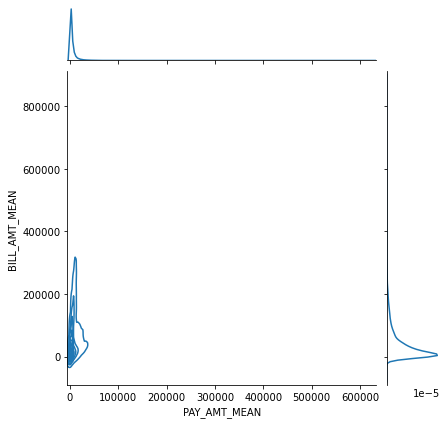

In [81]:
seaborn.jointplot(x = ccd['PAY_AMT_MEAN'], y = ccd['BILL_AMT_MEAN'], kind = 'kde')#, hue = 'default payment next month')

Conclusion - 
1. The correlation between PAY_AMT_MEAN and BILL_AMT_MEAN is not insignificant (0.597273, Table 1). However for lower defaulter ratio, this correlation should be improved.

### 3.2.j default payment next month
Type - Categorical - Nominal

Segment - Behavioural - {Target for Classification}

Legend - {True, False}

In [82]:
#for dictionary
ccd['default_payment_next_month'].value_counts()

False    23364
True      6636
Name: default_payment_next_month, dtype: int64

In [83]:
ccd['default_payment_next_month'].value_counts(normalize = True).mul(100).round(2).astype('str') + '%'

False    77.88%
True     22.12%
Name: default_payment_next_month, dtype: object

Expectation - 
1. There will be far less defaulters than on-time payers.

Conclusion - 
1. True. (False: 77.88%, True: 22.12%) (Distribution)

Comments - None

## 3.3 Multivariate Analysis

### One-Way MANOVA (Multivariate Analysis of Variance)

#### a. For Personality

In [84]:
personality = MANOVA.from_formula(formula = 'SEX + EDUCATION + MARRIAGE + AGE ~ default_payment_next_month', data = ccd)

In [85]:
personalityTest = personality.mv_test()

In [86]:
personalityTest.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Multivariate linear model
=============================================================================================
                                                                                             
---------------------------------------------------------------------------------------------
       Intercept               Value         Num DF   Den DF           F Value         Pr > F
---------------------------------------------------------------------------------------------
          Wilks' lambda               0.0000 9.0000 29990.0000 968193210213911936.0000 0.0000
         Pillai's trace               1.0000 9.0000 29990.0000 968193210213911936.0000 0.0000
 Hotelling-Lawley trace 290554814669063.2500 9.0000 29990.0000 968193210213911936.0000 0.0000
    Roy's greatest root 290554814669063.2500 9.0000 29990.0000 968193210213911808.0000 0.0000
---------------------------------------------------------------------------------------------
                                                                                             
--------------------------------------------------------------------------------------------------
       default_payment_next_month      Value       Num DF        Den DF        F Value      Pr > F
--------------------------------------------------------------------------------------------------
                    Wilks' lambda      0.9921      8.0000      29991.0000      29.7609      0.0000
                   Pillai's trace      0.0079      8.0000      29991.0000      29.7609      0.0000
           Hotelling-Lawley trace      0.0079      8.0000      29991.0000      29.7609      0.0000
              Roy's greatest root      0.0079      8.0000      29991.0000      29.7609      0.0000
=============================================================================================

"""

#### Conclusion:

Pillai's trace for target variable being 0.0079, personality traits are insignificant in predicting 'default_payment'.

#### b. For Financial habits

In [87]:
financialHabits = MANOVA.from_formula(formula = 'LIMIT_BAL + PAY_MODE_SEVEREST + BILL_AMT_MEAN + PAY_AMT_MEAN ~ default_payment_next_month', data = ccd)

In [88]:
financialHabitsTest = financialHabits.mv_test()

In [89]:
financialHabitsTest.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Multivariate linear model
===============================================================================================
                                                                                               
-----------------------------------------------------------------------------------------------
       Intercept               Value          Num DF   Den DF           F Value          Pr > F
-----------------------------------------------------------------------------------------------
          Wilks' lambda               0.0000 14.0000 29985.0000 1205718168095572224.0000 0.0000
         Pillai's trace               1.0000 14.0000 29985.0000 1205718168095572224.0000 0.0000
 Hotelling-Lawley trace 562949953421311.0000 14.0000 29985.0000 1205718168095572224.0000 0.0000
    Roy's greatest root 562949953421311.0000 14.0000 29985.0000 1205718168095572224.0000 0.0000
-----------------------------------------------------------------------------------------------
                                                                                               
----------------------------------------------------------------------------------------------------
       default_payment_next_month      Value        Num DF        Den DF        F Value       Pr > F
----------------------------------------------------------------------------------------------------
                    Wilks' lambda      0.8740      13.0000      29986.0000      332.6759      0.0000
                   Pillai's trace      0.1261      13.0000      29986.0000      332.7059      0.0000
           Hotelling-Lawley trace      0.1442      13.0000      29986.0000      332.6497      0.0000
              Roy's greatest root      0.1441      13.0000      29986.0000      332.4680      0.0000
===============================================================================================

"""

Conclusion: 

Pillai's trace for target variable being 0.1261, financial habits are significant in predicting 'default_payment' to some degree, but not very significant.

#### c. Using highly skewed variables

In [90]:
skewedVars = MANOVA.from_formula(formula = 'LIMIT_BAL + AGE + PAY_AMT_MEAN + BILL_AMT_MEAN + PAY_MODE_SEVEREST ~ default_payment_next_month', data = ccd)

In [91]:
skewedVarsTest = skewedVars.mv_test()

In [92]:
skewedVarsTest.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Multivariate linear model
================================================================================================
                                                                                                
------------------------------------------------------------------------------------------------
       Intercept                Value          Num DF   Den DF           F Value          Pr > F
------------------------------------------------------------------------------------------------
          Wilks' lambda                0.0000 15.0000 29984.0000 2000532314475212032.0000 0.0000
         Pillai's trace                1.0000 15.0000 29984.0000 2000532314475212032.0000 0.0000
 Hotelling-Lawley trace 1000799917193442.5000 15.0000 29984.0000 2000532314475212032.0000 0.0000
    Roy's greatest root 1000799917193442.5000 15.0000 29984.0000 2000532314475212032.0000 0.0000
------------------------------------------------------------------------------------------------
                                                                                                
-----------------------------------------------------------------------------------------------------
        default_payment_next_month      Value        Num DF        Den DF        F Value       Pr > F
-----------------------------------------------------------------------------------------------------
                     Wilks' lambda      0.8727      14.0000      29985.0000      312.4579      0.0000
                    Pillai's trace      0.1274      14.0000      29985.0000      312.6844      0.0000
            Hotelling-Lawley trace      0.1458      14.0000      29985.0000      312.2602      0.0000
               Roy's greatest root      0.1452      14.0000      29985.0000      310.8984      0.0000
================================================================================================

"""

Conclusion: 

Pillai's trace for target variable being 0.1274, highly skewed variables are significant in predicting 'default_payment' to some degree, but not very significant.